<h1><center>Trabajo Practico 2019 - Reciclaje en CABA</center></h1>
<h3><center>Pesaje Recibido en Puntos Verdes (2015-2016) en kilogramos</center></h3>

### Primero importamos las librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft


## PONER LAS LIBRERIAS A MEDIDA QUE LAS USO
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

### Importamos el Dataset de reciclaje

In [2]:
comas_por_puntos = lambda x : (x.replace('.', '').replace(',', '.'))

filename = r'C:\Users\leoma\Desktop\UTN\Ciencia de Datos\DataSets\TP2019\pesaje-recibido-en-puntos-verdes-2015-2016.csv'
pesajes = pd.read_csv(filename, delimiter=';', decimal='.',
          converters = {'VIDRIO':comas_por_puntos,'PAPEL_Y_CARTON':comas_por_puntos,'METAL':comas_por_puntos,'PLASTICO_PET':comas_por_puntos,
                        'TELGOPOR':comas_por_puntos,'PLASTICOS_TODOS_LOS_DEMAS':comas_por_puntos,'TETRA_BRICK':comas_por_puntos,'PEQUENIOS_ELECTRODOMESTICOS':comas_por_puntos,
                        'APARATOS_ELECTRONICOS_EN_DESUSO':comas_por_puntos,'AVUS':comas_por_puntos})

### Hacemos una primera vision superficial del Dataset

In [3]:
print(f'\nPesajes tiene: {np.shape(pesajes)[0]} filas y {np.shape(pesajes)[0]} columnas')
pesajes.head(3)


Pesajes tiene: 3080 filas y 3080 columnas


,PUNTO,COMUNA,ANIO,MES,SEMANA,VIDRIO,PAPEL_Y_CARTON,METAL,PLASTICO_PET,TELGOPOR,PLASTICOS_TODOS_LOS_DEMAS,TETRA_BRICK,PEQUENIOS_ELECTRODOMESTICOS,APARATOS_ELECTRONICOS_EN_DESUSO,AVUS
0,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,1,31.2,20.7,0.27,,0,13.41,0,,,
1,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,2,2.231,44.878,0,,0,37.886,0.54,,,
2,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,3,38.042,27.763,1.067,,0,17.57,0,,,


In [4]:
comunas_distintas = np.unique(pesajes.COMUNA)
print(f'Hay {len(comunas_distintas)} comunas distintas')
puntos_distintos = np.unique(pesajes.PUNTO)
print(f'Hay {len(puntos_distintos)} puntos distintos distribuidos entre las comunas')

Hay 15 comunas distintas
Hay 32 puntos distintos distribuidos entre las comunas


In [5]:
# Primero reemplazo las cadenas vacias y los espacios ' ' por valor NaN para poder contarlos mas facil
pesajes = pesajes.replace('', np.nan).replace(' ', np.nan)
total = pesajes.isnull().sum().sort_values(ascending=False)
percent = (pesajes.isnull().sum()/pesajes.isnull().count()).sort_values(ascending=False)
nulos = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
nulos

,Total,Porcentaje
AVUS,2993,0.971753
APARATOS_ELECTRONICOS_EN_DESUSO,2872,0.932468
PEQUENIOS_ELECTRODOMESTICOS,2872,0.932468
PLASTICO_PET,1284,0.416883
TETRA_BRICK,738,0.239610
TELGOPOR,371,0.120455
METAL,371,0.120455
PAPEL_Y_CARTON,371,0.120455
VIDRIO,370,0.120130
PLASTICOS_TODOS_LOS_DEMAS,369,0.119805


<h1><center>Limpieza y transformación del Dataset para su cómodo uso</center></h1>

#### Decidimos eliminar la columna de AVUs, y las de eletrodomesticos por tener menos del 90% de los datos
(solo estan en 2 comunas)

In [6]:
pesajes = pesajes.iloc[:,0:12]

#### Los PLASTICO_PET son de los materiales mas comunmente reciclables y lamentablemente es la columna de peor condición. Las filas, además de sus registros nulos, tambien poseen en su mayoria valores 0. Por lo tanto decidimos eliminarla también.

In [7]:
vaciosPET = np.shape(pesajes.loc[(pesajes['PLASTICO_PET'] == "0")])[0] + pesajes.isnull().sum()[8]
print("Valores vacios en PLASTICO_PET: " + str(vaciosPET))

Valores vacios en PLASTICO_PET: 2311


In [8]:
pesajes = pesajes.iloc[:,[0,1,2,3,4,5,6,7,9,10,11]]
pesajes.head(3)

,PUNTO,COMUNA,ANIO,MES,SEMANA,VIDRIO,PAPEL_Y_CARTON,METAL,TELGOPOR,PLASTICOS_TODOS_LOS_DEMAS,TETRA_BRICK
0,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,1,31.2,20.7,0.27,0,13.41,0
1,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,2,2.231,44.878,0,0,37.886,0.54
2,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,3,38.042,27.763,1.067,0,17.57,0


#### Transformamos los meses a valores numéricos y separamos los años

In [9]:
meses = ["ENERO","FEBRERO","MARZO","ABRIL","MAYO","JUNIO","JULIO","AGOSTO","SEPTIEMBRE","OCTUBRE","NOVIEMBRE","DICIEMBRE"]
for i in range (1,13):
    pesajes.loc[ pesajes['MES'] == meses[i-1], 'MES'] = i

# Separo 2015 y 2016
pesajes_2015 = pesajes.loc[pesajes['ANIO'] == 2015]
pesajes_2016 = pesajes.loc[pesajes['ANIO'] == 2016]

#### El Dataset termina a la tercera semana de Septiembre de 2016 para todas las comunas excepto 2. Decidimos eliminar los siguientes meses para todas las comunas.

In [10]:
# Almacenamos los meses 10,11 y 12 de 2016 para las 2 comunas especiales (PLAZA ARENALES y PARQUE CENTENARIO)
pesajes_extra_Arenales_Centenario = pesajes.loc[((pesajes['ANIO'] == 2016) & (pesajes['MES'].isin([10,11,12])) & (pesajes['PUNTO'].isin(['PLAZA ARENALES','PARQUE CENTENARIO'])))]
pesajes_extra_Arenales_Centenario.head()

# Eliminamos los ultimos 3 meses
pesajes = pesajes.loc[~((pesajes['ANIO'] == 2016) & (pesajes['MES'].isin([10,11,12])))]

##   Criterios elegidos para limpiar el Dataframe de datos inutilizables faltantes
Dada la gran cantidad de datos faltantes o vacios, expresados de diversas formas, elegimos un criterio para seleccionar los puntos mas prometedores para trabajar.
### 1) Semana
    Si una semana esta llena de 0s, "", " ", NaNs es considerada VACIA
### 2) Mes
    Si un mes tiene 3 o más semanas VACIAS -> Esta VACIO
    Si un mes no esta cargado en el dataframe -> Esta VACIO
### 3) Punto
    Si un Punto tiene 4 o mas meses VACIOS en 2015 y 2016 -> Esta VACIO

#### Cuento los meses que aparecen tienen 3 o mas semanas vacias

In [11]:
#Primero filtro las que tienen meses con todas las filas llenas de cero (si tienen esas 3 vacias, el resto tambien)
filtro1 = pesajes_2015['VIDRIO'].isin([0,np.nan," "])
filtro2 = pesajes_2015['PAPEL_Y_CARTON'].isin([0,np.nan," "])
sin_vacio = (filtro1 & filtro2)
pesajes_2015_semanas_vacias = pesajes_2015[sin_vacio].drop_duplicates().sort_values(by=['PUNTO', 'MES','SEMANA']).copy().reset_index(drop=True)

filtro1 = pesajes_2016['VIDRIO'].isin([0,np.nan," "])
filtro2 = pesajes_2016['PAPEL_Y_CARTON'].isin([0,np.nan," "])
sin_vacio = (filtro1 & filtro2)
pesajes_2016_semanas_vacias = pesajes_2016[sin_vacio].drop_duplicates().sort_values(by=['PUNTO', 'MES','SEMANA']).copy().reset_index(drop=True)

#### Junto todas las tablas en una que muestre el estado de los Puntos segun datos vacios y faltantes

In [12]:
## Creo un df de los meses que tengo cargados de cada año, ordenados
meses_cargados_2015 = pesajes_2015.iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES']).copy().reset_index(drop=True)
meses_cargados_2016 = pesajes_2016.iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES']).copy().reset_index(drop=True)
    
## Los comparo y obtengo un df de todos los meses faltantes con PUNTO y MES
meses_faltantes = pd.merge(meses_cargados_2015, meses_cargados_2016,how='outer', indicator=True).query('_merge == "left_only"')
meses_faltantes_por_barrio = meses_faltantes.groupby(["PUNTO"])["MES"].count().sort_values(ascending=False)

Tabla_Faltantes = pd.concat([meses_faltantes_por_barrio], axis=1, keys=['Meses faltantes por barrio en 2016'])
Tabla_de_Vacios_Completa = (meses_faltantes.iloc[:,0:2]).groupby(["PUNTO"])["MES"].count().sort_values(ascending=False)
Tabla_de_Vacios_Completa = Tabla_de_Vacios_Completa.to_frame().rename(columns = {"MES":"Faltantes_2016"})

Agregar_a_tabla_vacias_filtrada_2016 = pesajes_2016_semanas_vacias.groupby(["PUNTO", "MES"]).filter(lambda x: x["SEMANA"].count() >= 3).iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES'])
Agregar_a_tabla_vacias_filtrada_2016 = Agregar_a_tabla_vacias_filtrada_2016.groupby(["PUNTO"]).size().to_frame().rename(columns = {0: "Vacios_2016"})
Agregar_a_tabla_vacias_filtrada_2015 = pesajes_2015_semanas_vacias.groupby(["PUNTO", "MES"]).filter(lambda x: x["SEMANA"].count() >= 3).iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES'])
Agregar_a_tabla_vacias_filtrada_2015 = Agregar_a_tabla_vacias_filtrada_2015.groupby(["PUNTO"]).size().to_frame().rename(columns = {0: "Vacios_2015"})

Tabla_de_Vacios_Completa = pd.merge(Tabla_de_Vacios_Completa, Agregar_a_tabla_vacias_filtrada_2016, how='left', on='PUNTO').fillna(0)
Tabla_de_Vacios_Completa = pd.merge(Tabla_de_Vacios_Completa, Agregar_a_tabla_vacias_filtrada_2015, how='left', on='PUNTO').fillna(0)
Tabla_de_Vacios_Completa['Meses_No_Utilizables'] = Tabla_de_Vacios_Completa.Faltantes_2016 + Tabla_de_Vacios_Completa.Vacios_2016 + Tabla_de_Vacios_Completa.Vacios_2015

#### Decidimos borrar estos 4 Puntos por no cumplir el criterio de meses Vacios que definimos.

In [13]:
pesajes_criterio_de_limpieza = pesajes.loc[~pesajes['PUNTO'].isin(['ESTACION VILLA SOLDATI','PLAZA 25 DE AGOSTO','PLAZA VELAZCO IBARRA','PLAZA SAN MARTIN'])]

# Muestro la tabla ordenada por Meses No utilizables. Solo muestro los que no cumplen el criterio de meses faltantes
Tabla_de_Vacios_Completa.sort_values(by=['Meses_No_Utilizables'],ascending=False).iloc[0:4,:]

,Faltantes_2016,Vacios_2016,Vacios_2015,Meses_No_Utilizables
PUNTO,,,,
PLAZA 25 DE AGOSTO,4,8.0,11.0,23.0
ESTACION VILLA SOLDATI,4,8.0,4.0,16.0
PLAZA VELAZCO IBARRA,3,0.0,4.0,7.0
PLAZA M BELGRANO,3,2.0,0.0,5.0


#### Observando el Dataset pudimos ver que existen muchos nulos en ciertas quintas semanas de 2015 y 2016, estas semanas al corroborar con el calendario tenian muy pocos días. Asuminos esta como la razon de porque no se cargaron en casi ninguna comuna y las eliminamos

Podemos ver el estado actual de nulos para compararlo cuando eliminemos las quintas semanas del mes 6 y 11 para 2015 y el mes 1 y 9 para 2016

In [14]:
pesajes_con_nulo = pesajes_criterio_de_limpieza.replace('', np.nan).replace(' ', np.nan)
pesajes_1 = pesajes_con_nulo.loc[~((pesajes_con_nulo['ANIO'] == 2015) & (pesajes_con_nulo['MES'] == 6) & (pesajes_con_nulo['SEMANA'] == 5))]
pesajes_2 = pesajes_1.loc[~((pesajes_1['ANIO'] == 2015) & (pesajes_1['MES'] == 11) & (pesajes_1['SEMANA'] == 5))]
pesajes_3 = pesajes_2.loc[~((pesajes_2['ANIO'] == 2016) & (pesajes_2['MES'] == 1) & (pesajes_2['SEMANA'] == 5))]
pesajes_sin_quinta_vacias = pesajes_3.loc[~((pesajes_3['ANIO'] == 2016) & (pesajes_3['MES'] == 9) & (pesajes_3['SEMANA'] == 5))]

pesajes_ordenado = pesajes_sin_quinta_vacias.sort_values(by=['ANIO','MES'])
print("Nulos restantes"); pesajes_ordenado.isnull().sum()[pesajes_ordenado.isnull().sum() > 0]

Nulos restantes


VIDRIO                        38
PAPEL_Y_CARTON                39
METAL                         39
TELGOPOR                      39
PLASTICOS_TODOS_LOS_DEMAS     37
TETRA_BRICK                  377
dtype: int64

#### Como termina en la tercera semana de Septiembre de 2016, la cuarta esta vacia. Decidimos llenar esta cuarta semana con una media da las primeras 3 semanas

In [15]:
for indice in range(0, len(pesajes_ordenado)):
    if ((pesajes_ordenado.iloc[indice,2:5] == [2016, 9, 4]).all()):
        media = round((pesajes_ordenado.iloc[indice-3,5:12].apply(lambda x: float(x)) +
                 pesajes_ordenado.iloc[indice-2,5:12].apply(lambda x: float(x)) +
                 pesajes_ordenado.iloc[indice-1,5:12].apply(lambda x: float(x)))
                 /3, 3)
        pesajes_ordenado.iloc[indice,5:12] = media.apply(lambda x: str(x))
        
#Relleno a mano 5 excepciones con las medias de los meses cercanos a ellas
for i in range (0,5):
    pesajes_ordenado.iloc[1996+i,5:12] = pesajes_ordenado.iloc[1967,5:12]
    
pesajes_ordenado.loc[2038,'PLASTICOS_TODOS_LOS_DEMAS'] = pesajes_ordenado.loc[2037,'PLASTICOS_TODOS_LOS_DEMAS']
print("Nulos restantes"); pesajes_ordenado.isnull().sum()[pesajes_ordenado.isnull().sum() > 0]

Nulos restantes


VIDRIO                        12
PAPEL_Y_CARTON                13
METAL                         13
TELGOPOR                      13
PLASTICOS_TODOS_LOS_DEMAS     10
TETRA_BRICK                  351
dtype: int64

#### El resto de nulos (sin incluir tetra_brick) que quedan los rellenamos haciendo un promedio de sus semanas llenas en ese mes.

In [16]:
pesajes_ordenado = pesajes_ordenado.replace('nan', np.nan)
VidriosNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,5].isnull()] #VIDRIOS
PyCNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,6].isnull()]     #PAPEL Y CARTON
MetalNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,7].isnull()]   #METAL
TelgoporNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,8].isnull()]#TELGOPOR
Plasticos = pesajes_ordenado[pesajes_ordenado.iloc[:,9].isnull()]    #PLASTICOS_TODOS_LOS_DEMAS
matsNulos = [VidriosNulos, PyCNulos, MetalNulos, TelgoporNulos, Plasticos]
material = ['VIDRIO','PAPEL_Y_CARTON','METAL','TELGOPOR','PLASTICOS_TODOS_LOS_DEMAS']

# Relleno con la media de las semanas restantes del mes con algunas nulas mas las del siguiente y el anterior
for m in range(0, 5):
    for i in range(0, len(matsNulos[m])):
        mesActual = matsNulos[m]['MES'].iloc[i]
        medias = (pesajes_ordenado.loc[(pesajes_ordenado['MES'].isin([mesActual, mesActual-1, mesActual+1])) & (pesajes_ordenado['ANIO'] == matsNulos[m]['ANIO'].iloc[i]) & (pesajes_ordenado['PUNTO'] == matsNulos[m]['PUNTO'].iloc[i]) & 
                                       (pesajes_ordenado[material[m]].notnull())].iloc[:,[5,6,7,9,10]]).apply(lambda x: x.apply(lambda x: float(x))).mean().apply(lambda x: str(round(x,2)))
        count = 0
        for c in ['VIDRIO','PAPEL_Y_CARTON','METAL','TELGOPOR','PLASTICOS_TODOS_LOS_DEMAS']:
            pesajes_ordenado.loc[matsNulos[m].index[i], c] = medias[count]
            count+=1

pesajes_ordenado = pesajes_ordenado.replace('nan', np.nan)
print("Nulos restantes"); pesajes_ordenado.isnull().sum()[pesajes_ordenado.isnull().sum() > 0]

Nulos restantes


TETRA_BRICK    352
dtype: int64

#### Por ultimo llenamos los Tetra Bricks que faltan usando las medias de las semanas(o mes en peor caso) anterior y siguiente

In [17]:
# En meses 1,2 y 3 de 2015 estan casi todos los vacios, los relleno con la media en el mismo punto de los meses 4 y 5
EneFebMar_TetraNulos = pesajes_ordenado.loc[(pesajes_ordenado['ANIO'] == 2015) & (pesajes_ordenado['MES'].isin([1,2,3])) & (pesajes_ordenado['TETRA_BRICK'].isnull())]

# Relleno con la media del los meses 4 y 5 que sean de mismo Punto
for i in range(0, len(EneFebMar_TetraNulos)):
    media = (pesajes_ordenado.loc[(pesajes_ordenado['MES'].isin([4,5])) & (pesajes_ordenado['ANIO'] == 2016) & (pesajes_ordenado['PUNTO'] == EneFebMar_TetraNulos['PUNTO'].iloc[i]) & 
                              (pesajes_ordenado['TETRA_BRICK'].notnull())].iloc[:,10]).apply(lambda x: float(x)).mean()
    media = str(round(media,2))
    pesajes_ordenado.loc[EneFebMar_TetraNulos.index[i],'TETRA_BRICK'] = media

# Los pocos Nulos faltantes los lleno las semanas con las medias de sus respectivos meses en sus respectivos puntos
TetraUltimosNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,10].isnull()]
for i in range(0, len(TetraUltimosNulos)):
    mesActual = TetraUltimosNulos['MES'].iloc[i]
    media = (pesajes_ordenado.loc[(pesajes_ordenado['MES'].isin([mesActual, mesActual-1, mesActual+1])) & (pesajes_ordenado['ANIO'] == TetraUltimosNulos['ANIO'].iloc[i]) & (pesajes_ordenado['PUNTO'] == TetraUltimosNulos['PUNTO'].iloc[i]) & 
                                  (pesajes_ordenado['TETRA_BRICK'].notnull())].iloc[:,10]).apply(lambda x: float(x)).mean()
    media = str(round(media,2))
    pesajes_ordenado.loc[TetraUltimosNulos.index[i],'TETRA_BRICK'] = media

print(f"\nVerificamos que no hayan quedado pesajes nulos  ->  {pesajes_ordenado.isnull().sum().any()}")


Verificamos que no hayan quedado pesajes nulos  ->  False


In [68]:
## Genero el archivo csv ya limpio y lo vuelvo a importar cambiando sus tipos a numeros flotantes para
## que sea mas facil su manejo
import os
export_csv = pesajes_ordenado.to_csv(r'pesajes_nulos.csv', index = None, header=True, sep=';')
filename = os.getcwd() + "\\pesajes_nulos.csv"
pesajes = pd.read_csv(filename, delimiter=';', decimal='.')

<h1><center>Análisis Exploratorio de Datos</center></h1>

### Importamos un Dataset relacionado para obtener de este las coordenadas de las comunas

In [69]:
filename = r'C:\Users\leoma\Desktop\UTN\Ciencia de Datos\DataSets\TP2019\puntos-verdes.csv'
puntos_verdes = pd.read_csv(filename, delimiter=',')

#### Lo exploramos un poco y nos quedamos solo con las columnas de Longitud, Latitud y Comuna

In [70]:
puntos_verdes = puntos_verdes.iloc[:,[0,1,14]]
puntos_verdes = puntos_verdes.dropna()
puntos_verdes.drop_duplicates().isnull().sum()

long      0
lat       0
comuna    0
dtype: int64

In [71]:
puntos_verdes.head()

,long,lat,comuna
0,-58.465309,-34.567226,Comuna 13
1,-58.424945,-34.589219,Comuna 14
2,-58.468392,-34.547087,Comuna 13
3,-58.503884,-34.576313,Comuna 12
4,-58.483452,-34.629626,Comuna 10


#### Traducimos las Comunas de ambos dataFrames a numeros para mergearlos

In [72]:
# Traducimos las comunas a solamente un numero y mergeamos los Dataframes

comunas_distintas_puntosVerdes = ['Comuna 1', 'Comuna 2', 'Comuna 3', 'Comuna 4', 'Comuna 5', 'Comuna 6', 'Comuna 7',
                                  'Comuna 8', 'Comuna 9', 'Comuna 10', 'Comuna 11', 'Comuna 12', 'Comuna 13', 'Comuna 14', 'Comuna 15']
comunas_distintas_Pesajes = ['COMUNA 1', 'COMUNA 2', 'COMUNA 3', 'COMUNA 4', 'COMUNA 5', 'COMUNA 6', 'COMUNA 7','COMUNA 8',
                             'COMUNA 9', 'COMUNA 10', 'COMUNA 11', 'COMUNA 12', 'COMUNA 13', 'COMUNA 14', 'COMUNA 15']
for i in range (1,16):
    puntos_verdes.loc[ puntos_verdes['comuna'] == comunas_distintas_puntosVerdes[i-1], 'comuna'] = i
    pesajes.loc[ pesajes['COMUNA'] == comunas_distintas_Pesajes[i-1], 'COMUNA'] = i

#### Centro los puntos de las comunas mediante la media de las coordenadas de sus puntos verdes y los alineo al mapa de CABA

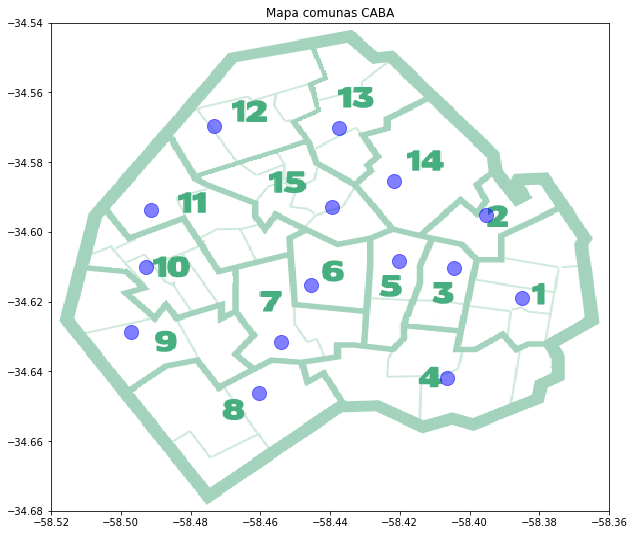

In [73]:
# Centro los puntos puntos_verdes en cada comuna
centros_puntos_verdes = puntos_verdes.groupby('comuna', as_index=False).agg('mean')

#Reacoomodo las coordenadas para que queden bien ubicadas en el mapa
centros_puntos_verdes.iloc[0,1] -= 0.01 # Longitud COMUNA 1 Si le resto va a la izq
centros_puntos_verdes.iloc[0,2] -= 0.01 # Latitud COMUNA 1 Si le resto baja
centros_puntos_verdes.iloc[1,1] += 0.003;centros_puntos_verdes.iloc[1,2] -= 0.005 # COMUNA 2
centros_puntos_verdes.iloc[2,1] -= 0.002;centros_puntos_verdes.iloc[2,2] += 0.005 # COMUNA 3
centros_puntos_verdes.iloc[3,1] -= 0.016 # COMUNA 4
centros_puntos_verdes.iloc[4,1] -= 0.004;centros_puntos_verdes.iloc[4,2] += 0.01 # COMUNA 5
centros_puntos_verdes.iloc[5,1] -= 0.004;centros_puntos_verdes.iloc[5,2] -= 0.001 # COMUNA 6
centros_puntos_verdes.iloc[7,1] += 0.004;centros_puntos_verdes.iloc[7,2] += 0.03 # COMUNA 8
centros_puntos_verdes.iloc[8,1] += 0.007;centros_puntos_verdes.iloc[8,2] += 0.018 # COMUNA 9
centros_puntos_verdes.iloc[9,1] += 0.007;centros_puntos_verdes.iloc[9,2] += 0.017 # COMUNA 10
centros_puntos_verdes.iloc[10,1] += 0.001;centros_puntos_verdes.iloc[10,2] += 0.01 # COMUNA 11
centros_puntos_verdes.iloc[11,1] += 0.015 # COMUNA 12
centros_puntos_verdes.iloc[12,1] += 0.015;centros_puntos_verdes.iloc[12,2] -= 0.01 # COMUNA 13
centros_puntos_verdes.iloc[13,2] -= 0.005 # COMUNA 14
centros_puntos_verdes.iloc[14,1] += 0.022 # COMUNA 15

BBox = (-58.52,-58.36,-34.68,-34.54)

mapa = plt.imread(r'C:\Users\leoma\Desktop\UTN\Ciencia de Datos\DataSets\TP2019\map - copia.png')

fig, ax = plt.subplots(figsize = (10,15))
ax.scatter(centros_puntos_verdes.long, centros_puntos_verdes.lat, zorder=1, alpha= 0.5, c='b', s=200)
ax.set_title('Mapa comunas CABA')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(mapa, zorder=0, extent = BBox, aspect= 'equal')

#### Agrego las coordenadas a nuestro Dataset original de pesajes

In [74]:
centros_puntos_verdes = centros_puntos_verdes.rename(columns = {"comuna": "COMUNA"})
pesajes_con_coordenadas = pd.merge(pesajes, centros_puntos_verdes, how='left', on='COMUNA')

In [75]:
## Los 3 conjuntos de Y que vamos a tratar de predecir
## MEDIA MENSUAL DE LOS DISTINTOS TIPOS DE RECICLABLES
pesajes_mediaSemanal = pesajes.iloc[:,[1,2,3,5,6,7,8,9,10]].groupby(["COMUNA","ANIO","MES"], as_index=False).mean()
pesajes_mediaSemanal.head(3)

## TOTAL MENSUAL DE LOS DISTINTOS TIPOS DE RECICLABLES
pesajes_totalMensual = pesajes.iloc[:,[1,2,3,5,6,7,8,9,10]].groupby(["COMUNA","ANIO","MES"], as_index=False).sum()
pesajes_totalMensual.head(3)

## CAMBIO RELATIVO CON RESPECTO AL MES ANTERIOR DE LOS DISTINTOS TIPOS DE RECICLABLES
#  Elimino primer mes porque no conozco su cambio relativo con su mes anterior
pesajes_cambioRelativo = pd.concat([pesajes_totalMensual.iloc[1:,[0,1,2]],pesajes_totalMensual.pct_change().iloc[1:,3:]], axis=1)
pesajes_cambioRelativo.head(3)

,COMUNA,ANIO,MES,VIDRIO,PAPEL_Y_CARTON,METAL,TELGOPOR,PLASTICOS_TODOS_LOS_DEMAS,TETRA_BRICK
1,1,2015,2,-0.136093,-0.067156,-0.271671,-0.630109,0.042966,-0.200000
2,1,2015,3,-0.088822,-0.007907,0.176431,-0.327413,0.366614,0.000000
3,1,2015,4,0.148648,-0.061896,-0.080993,4.022458,0.034014,-0.587009


In [76]:
mediaSemanal_por_comuna = pd.pivot_table(pesajes_mediaSemanal,values = 'VIDRIO',columns = 'COMUNA', index = pesajes_mediaSemanal.MES.values, aggfunc = np.mean)

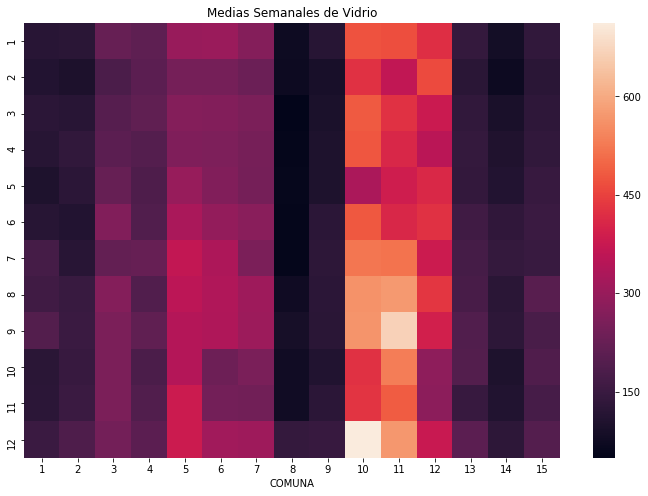

In [77]:
plt.figure(figsize=(12,8))
sns.heatmap(mediaSemanal_por_comuna)
plt.title("Medias Semanales de Vidrio")


plt.show()

In [78]:

scaler = preprocessing.StandardScaler().fit(pesajes_totalMensual.iloc[:,3:])

pesajes_totalMensual_scal = pesajes_totalMensual.copy()
pesajes_totalMensual_scal.iloc[:,3:] = scaler.transform(pesajes_totalMensual.iloc[:,3:])  

In [79]:
totalMensual_por_comuna = pd.pivot_table(pesajes_totalMensual_scal,values = 'TELGOPOR',columns = 'COMUNA', index = pesajes_mediaSemanal.MES.values, aggfunc = np.sum)

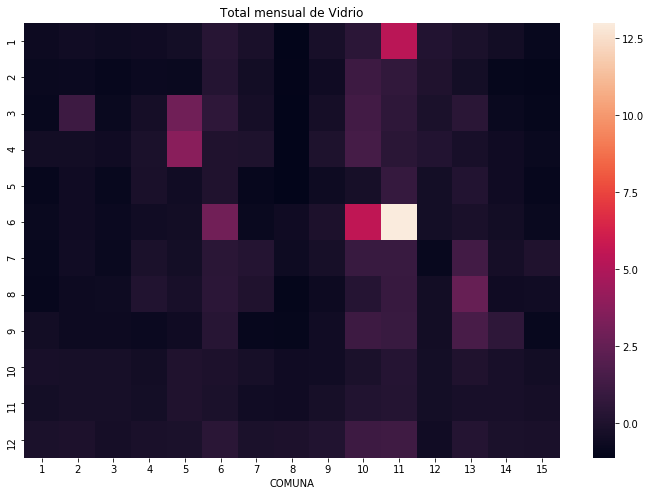

In [80]:
plt.figure(figsize=(12,8))
sns.heatmap(totalMensual_por_comuna)
plt.title("Total mensual de Vidrio")


plt.show()

In [81]:
## Grafico de distribuciones de los pesajes en las distintas comunas (capaz un grafico
#  que este superpueste de todos los vidrios y por cada comuna o algo asi)
#  Ver como son las distribuciones en general de cada material (Capaz son distintas)

<h1><center>Modelo Clasificador de Comunas</center></h1>

### Decidimos crear un modelo supervisado clasificador que prediga como salida la comuna a la que pertenece una lista semanal de pesajes  que ingresa como entrada. 
### Nuestra hipotesis es que las comunas tienen combinaciones distintas de distribuciones para cada pesaje, lo que les otorga una cualidad unica para, en caso de detectarla, poder predecir de que comuna es una lista semanal de pesajes.

In [82]:
## y un modelo clasificador de puntos?
# np.shape(np.unique(pesajes['PUNTO']))

#### Realizamos un Filtrado de Outliers, para que nuestro modelo no este sesgado por anomalías.

In [83]:
## Obtengo los percentiles 97 de cada pesaje y filtro mi dataset por cada uno

Elegimos filtrar por 
quantile = 0.97
pesajes = pesajes.loc[(pesajes['VIDRIO'] < pesajes['VIDRIO'].quantile(quantile)) &
                      (pesajes['PAPEL_Y_CARTON'] < pesajes['PAPEL_Y_CARTON'].quantile(quantile)) &
                      (pesajes['METAL'] < pesajes['METAL'].quantile(quantile)) &
                      (pesajes['TELGOPOR'] < pesajes['TELGOPOR'].quantile(quantile)) &
                      (pesajes['TETRA_BRICK'] < pesajes['TETRA_BRICK'].quantile(quantile)) &
                      (pesajes['PLASTICOS_TODOS_LOS_DEMAS'] < pesajes['PLASTICOS_TODOS_LOS_DEMAS'].quantile(quantile))]

# Agregar filtro con PCA si me queda tiempo

In [87]:
# Guardamos feature matrix en "x"
x = pesajes.iloc[:,2:] 

# Guardamos target vector in "y"
y = pesajes.iloc[:,1]

In [86]:
np.shape(pesajes)

(2301, 11)

### Train, Test y escalo

In [37]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=4)

### Feature Selection

In [38]:
# umbral para definir con que % de features nos quedamos
thresh = 0.2

In [39]:
#xtrain_scal_red_var = xtrain.iloc[:,
#               (np.std(xtrain)>np.quantile(np.std(xtrain), thresh)).values]
#xtest_scal_red_var = xtest.iloc[:,
#               (np.std(xtrain)>np.quantile(np.std(xtrain), thresh)).values]
# El test lo estoy filtrando por el desvio y cuantil del train
Features_Seleccionadas = (np.std(xtrain)>np.quantile(np.std(xtrain), thresh)).values
Features_Seleccionadas[0:2] = True # Dejo las fechas
xtrain = xtrain.iloc[:,Features_Seleccionadas]
xtest = xtest.iloc[:,Features_Seleccionadas]
# El test lo estoy filtrando por el desvio y cuantil del train

In [40]:
print("La cantidad de Features seleccionadas son " + str(np.shape(xtrain)[1]))

La cantidad de Features seleccionadas son 8


In [41]:
print("La cantidad de Features seleccionadas son " + str(np.shape(xtest)[1]))

La cantidad de Features seleccionadas son 8


In [42]:
xtrain.head()

,ANIO,MES,VIDRIO,PAPEL_Y_CARTON,METAL,TELGOPOR,PLASTICOS_TODOS_LOS_DEMAS,TETRA_BRICK
1235,2015,11,265.379,340.922,34.232,4.329,160.611,15.691
47,2015,1,331.990,357.710,9.450,0.640,128.670,19.340
777,2015,7,217.594,325.507,17.507,0.855,117.765,3.215
1425,2015,12,249.050,342.530,21.030,3.230,145.240,3.150
767,2015,7,288.134,345.647,9.883,0.000,163.658,5.771


In [43]:
np.shape(xtest)

(691, 8)

In [44]:
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [45]:
# xtrain_scal tendra el dataset de train pre-procesado con el standard scaler
xtrain_scal = scaler.transform(xtrain)
# para cada feature imprimimos la media y el desvio standard obtenido. Ver que media = 0 y stdev = 1.
print(xtrain_scal.mean(axis=0))
print(xtrain_scal.std(axis=0))
# veo que me queda media casi 0 y desvío 1

[ 4.57218804e-15 -9.70927962e-17 -2.42731990e-17  3.75131258e-17
  4.30297619e-17 -7.72329061e-17  5.51663615e-18 -1.02609432e-16]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [46]:
# utilizando el scaler "fiteado" o "ajustado" a los datos de train, aplicamos el scaler a los datos de test.
# obtenemos "xtest_scal" 
xtest_scal = scaler.transform(xtest) 
# obviamente la media y stdev de las features en test no seran 0 y 1 ya que el scaler se ajusto con train unicamente.
print(xtest_scal.mean(axis=0))
print(xtest_scal.std(axis=0))

[-1.84989999e-02  3.76817379e-02 -2.24675333e-02 -4.45582478e-02
  7.04905125e-05 -1.04789315e-02 -2.88102056e-02  3.16263238e-03]
[0.99592209 0.99016541 1.03960794 1.04537448 1.01883919 1.00933408
 1.01919079 0.98985724]


## KNN

In [47]:
# defino modelo KNN llamado "neigh" y le asigno el hiper-parametro n_neighbors = 5
neigh = KNeighborsClassifier(n_neighbors=10)

In [48]:
# Ajusto mi modelo a las muestras de training utilizando tanto Xtrain como Ytrain
neigh.fit(xtrain_scal, ytrain) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [49]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = neigh.predict(xtest_scal)

In [50]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.4211287988422576


In [51]:
# Compute confusion Matrix
cm = confusion_matrix(ytest, ypred)
cm

array([[34,  1,  1,  3,  3,  4,  3,  0,  1,  1,  0,  0,  1,  2,  0],
       [ 2, 25,  1,  5,  0,  1,  0,  3,  5,  0,  0,  0,  2,  6,  2],
       [ 1,  6, 10,  0,  5,  0,  4,  0,  2,  0,  0,  0,  2,  0,  1],
       [ 2,  5,  5, 19,  1,  1,  6,  3,  1,  0,  0,  0,  7,  0,  1],
       [ 5,  0,  4,  2, 31,  1,  3,  0,  0,  6,  0,  1,  0,  1,  0],
       [ 2,  6,  0,  5,  5, 21,  0,  0,  0,  1,  3,  1,  3,  0,  0],
       [ 7,  4,  0,  7,  9,  3, 13,  0,  1,  1,  1,  0,  1,  0,  0],
       [ 1,  3,  0,  1,  0,  0,  0,  8,  9,  0,  0,  0,  2,  3,  0],
       [ 2,  3,  0,  1,  0,  1,  2,  1, 24,  0,  0,  1,  8,  5,  4],
       [ 2,  0,  1,  2,  5,  1,  1,  0,  0, 20,  2,  4,  1,  0,  0],
       [ 0,  1,  1,  3,  1,  9,  1,  0,  0,  2, 15,  2,  0,  0,  0],
       [ 1,  1,  0,  3,  3,  4,  1,  0,  0,  3,  0, 23,  3,  1,  0],
       [ 3, 11,  5,  7,  2,  0,  3,  5,  3,  1,  0,  1, 27,  4,  2],
       [ 8,  5,  2,  2,  1,  0,  1,  8, 10,  0,  0,  0,  4, 15,  0],
       [ 0,  2,  2,  3,  1,  1,  0

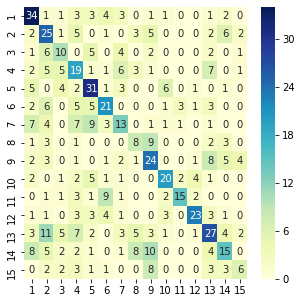

In [52]:
#df_cm = pd.DataFrame(cm, index = ['Cancer', 'Control'], columns = ['Cancer', 'Control'])
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],
                     columns = [i for i in np.unique(y)])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()

In [53]:
# indicamos la cantidad de valores que queremos probar y lo guardamos en "iteraciones_knn"
iteraciones_knn = 50
# creo un vector de 50 posiciones para guardar los resultados de accuracy.
acc_knn = np.zeros(iteraciones_knn)

In [54]:
# hago un for loop para ir entrenando un clasificador en cada iteracion e ir probando distintos valores de k
for r in range(0,iteraciones_knn):
    # entreno un KNN classifier con "k=r+1"
    neigh = KNeighborsClassifier(n_neighbors=r+1)
    neigh.fit(xtrain_scal,ytrain)
    # calculo la prediccion
    ypred_knn = neigh.predict(xtest_scal)
    # guardo el resultado de prediccion en la posicion r del vector "acc_knn"
    acc_knn[r] = accuracy_score(ytest, ypred_knn)

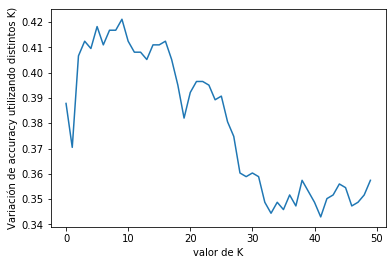

In [55]:
# imprimimos en pantalla el accuracy para cada valor de K
# vemos que con un valor de 5 obtenemos 0.9 de accuracy.
plt.plot(acc_knn)
plt.xlabel("valor de K")
plt.ylabel("Variación de accuracy utilizando distintos K)")
plt.show()

### SVM

In [56]:
# fit gaussian (RBF, gausiano) SVM con: 
# Cross Validation = 5
# GridSearch con todos los parametros a probar
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Uso una escala exponencial como se ve en C (penalizacion, mientras mas grande mas 
# sensible) y en gamma, asi abarco un mayor rango

# ********************* Gamma dice cuan flexible/lineal es *********************
#parameters = {'kernel':('rbf'), 'C':[1, 10, 100, 1000],
#              'gamma':[0.0001,0.001, 0.01, 0.1,1, 10,100]}

parameters = [{'kernel': ['rbf'],
               'gamma': [0.01,0.1,1,10],
               'C': [1,3,5,10]}]

#parameters = [{'kernel': ('rbf', 'linear'),
#               'gamma': [0.01,0.1,1,10],
#               'C': [1,3,5,10]}]

svc = svm.SVC()
clf = GridSearchCV(svc, param_grid = parameters, refit = True, cv = 10)
# cv indica la cantidad de folds.
# refit nos permite ajustar la muestra al final con los mejores parametros encontrados 
clf.fit(xtrain_scal, ytrain.ravel())
#.ravel() toma el (90,) de y lo acomoda para poder usarlo, creo que le agrega un 1 
# en la columna o algo asi, problema que a veces tiene el target

#Non-linear SVM

#model = SVC(C=1.0, kernel='rbf', gamma = 'auto' )
#model.fit(xtrain_scal, ytrain.ravel())

scores = clf.cv_results_

C:\Users\leoma\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [57]:
print("The best parameters are %s with a score of %0.2f" % 
      (clf.best_params_, clf.best_score_))
#rbf es kernel gaussiano
#no siempre es bueno que el score sea taaan alto porque puede referirse que estoy
#ajustando demaciado el modelo a mis datos, haciendo "overfitting"

The best parameters are {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} with a score of 0.47


In [58]:
# prediction sobre las muestras de test
y_pred=clf.predict(xtest_scal) 

In [59]:
# Model prediciton
print(clf.score(xtest_scal,ytest.ravel()))
#obtenemos el promedio de la accuracy

0.4630969609261939


In [60]:
#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print(cm)

[[31  1  2  5  1  3  7  0  0  1  0  0  1  2  0]
 [ 2 21  1  5  0  1  1  3  4  0  0  0  3  7  4]
 [ 0  2 11  0  8  0  3  0  3  0  0  0  1  0  3]
 [ 2  1  3 24  0  0  6  0  2  1  0  1  9  0  2]
 [ 3  1  0  2 35  0  3  0  0  9  0  0  1  0  0]
 [ 1  4  1  5  4 22  2  0  0  0  5  0  3  0  0]
 [ 4  2  0  5  7  4 10  1  1  3  1  3  4  2  0]
 [ 2  0  0  3  0  0  0  9  7  0  0  0  4  2  0]
 [ 2  2  1  1  0  0  1  1 26  0  0  0  5  8  5]
 [ 0  0  2  2  2  0  1  0  0 25  3  3  1  0  0]
 [ 0  0  1  3  0  6  0  0  0  1 21  2  1  0  0]
 [ 1  1  0  3  0  0  7  0  0  3  1 26  1  0  0]
 [ 2  6  2  4  2  0  1  4  8  0  2  1 35  3  4]
 [ 6  3  1  1  0  0  1  7 15  0  0  0 10 12  0]
 [ 0  2  1  2  1  0  0  0  6  0  0  0  4  1 12]]


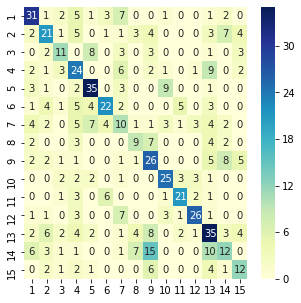

In [61]:
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],
                     columns = [i for i in np.unique(y)])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()

### Logistic regresion

In [62]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=42, solver='lbfgs')

In [63]:
lr_model.fit(xtrain_scal, ytrain) 
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = lr_model.predict(xtest_scal)
# Computo el accuracy (comparar ytest vs ypred)
test_acc2 = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc2))

El accuracy es 0.27496382054992763


C:\Users\leoma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


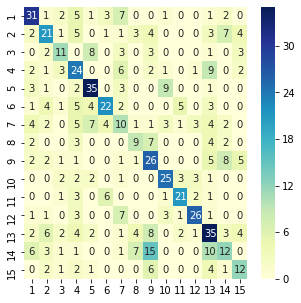

In [64]:
cm = confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],
                     columns = [i for i in np.unique(y)])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()